## ResNet50


In [2]:
import numpy as np
import pickle
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet50 import preprocess_input

# Path to your local CIFAR-100 folder
base_path = 'cifar-100-python'

# Helper to load train/test CIFAR-100
def load_cifar100_batch(file_name):
    with open(os.path.join(base_path, file_name), 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    return data['data'], data['fine_labels']

# Load data
x_train, y_train = load_cifar100_batch('train')
x_test, y_test = load_cifar100_batch('test')

# Reshape to (N, 32, 32, 3)
x_train = x_train.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype(np.uint8)
x_test = x_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1).astype(np.uint8)

# Labels to one-hot
y_train = to_categorical(np.array(y_train), 100)
y_test = to_categorical(np.array(y_test), 100)

# Define batch size
batch_size = 128
IMG_SIZE = 224

# Define preprocessing function for tf.data pipeline
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = preprocess_input(image)
    return image, label

# Create efficient datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(50000).map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("✅ Loaded and preprocessed CIFAR-100 for ResNet50 input!")


✅ Loaded and preprocessed CIFAR-100 for ResNet50 input!


In [3]:
# Load fine label names (optional display)
def load_cifar100_meta():
    with open(os.path.join(base_path, 'meta'), 'rb') as file:
        meta = pickle.load(file, encoding='latin1')
    return meta['fine_label_names']

fine_labels = load_cifar100_meta()
print(f"Total labels: {len(fine_labels)}")

Total labels: 100


In [4]:
# Data augmentation
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])


In [5]:
# Build improved ResNet50 model using functional API
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model


In [6]:
# Load base model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = True

In [7]:
# Fine-tune top 30 layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [8]:
# Build full model
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(100, activation='softmax')(x)

model = Model(inputs, outputs)

In [9]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

# Add EarlyStopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [11]:
# Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 100)       │     51,300 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,688,100 (94.18 MB)

 Trainable params: 15,550,564 (59.32 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [12]:
# Train the model
epochs = 20
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[early_stop]
)

Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2611s 7s/step - accuracy: 0.1393 - loss: 3.9592 - val_accuracy: 0.5560 - val_loss: 1.6250
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 3052s 8s/step - accuracy: 0.5101 - loss: 1.8491 - val_accuracy: 0.6515 - val_loss: 1.2667
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2944s 8s/step - accuracy: 0.6082 - loss: 1.4103 - val_accuracy: 0.6852 - val_loss: 1.1159
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2778s 7s/step - accuracy: 0.6694 - loss: 1.1682 - val_accuracy: 0.6938 - val_loss: 1.0845
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2870s 7s/step - accuracy: 0.7180 - loss: 0.9932 - val_accuracy: 0.7163 - val_loss: 1.0189
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2758s 7s/step - accuracy: 0.7506 - loss: 0.8735 - val_accuracy: 0.7216 - val_loss: 1.0198
Epoch 7/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2764s 7s/step - accuracy: 0.7783 - loss: 0.7686 - val_accuracy: 0.7241 - val_loss: 1.0254
Epoch 8/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 2803s 7s/step - accuracy: 0.8026 - loss: 0.6737 - 

In [13]:
import matplotlib.pyplot as plt

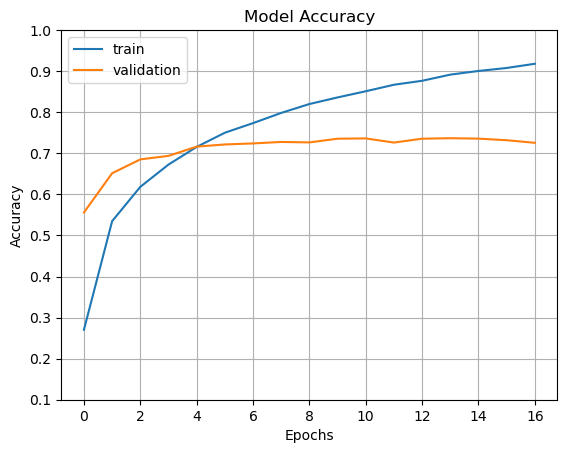

In [14]:
#Evaluating The Model
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

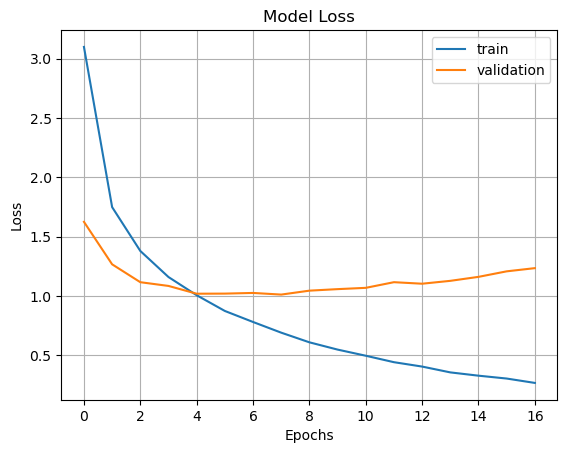

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()